# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertNoError(err error) {
    if err != nil { panic(err) }
}

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    AssertNoError(cifar.DownloadCifar10(*flagDataDir))
    AssertNoError(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 323M
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Jul  6 16:33 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Jul  6 16:33 cifar-10-binary.tar.gz


### Sample some images

The `cifar.NewDataset` creates a `data.InMemoryDataset` that can be used both for training, evaluation, or just to sample a few examples, which we do below:

Samples Cifar-10

automobile ([1]),frog ([6]),horse ([7]),truck ([9]),frog ([6]),airplane ([0]),automobile ([1]),automobile ([1])

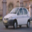
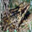
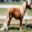
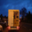
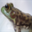
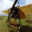
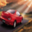
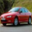

Samples Cifar-100

orchid ([54]),camel ([15]),wolf ([97]),oak_tree ([52]),poppy ([62]),palm_tree ([56]),man ([46]),orange ([53])

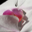
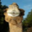
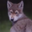
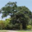
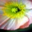
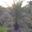
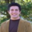
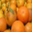

In [4]:
import (
    "strings"
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"
    timage "github.com/gomlx/gomlx/types/tensor/image"
    "github.com/janpfeifer/gonb/gonbui"
)

var (
    // Model DType, used everywhere.
    DType = shapes.F32
    
    // Global manager, also used for all graphs.
    manager = NewManager()
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook() {
    // Load data into tensors.
    ds10 := cifar.NewDataset(manager, "Samples Cifar-10", *flagDataDir, cifar.C10, DType, cifar.Train).Shuffle()
    ds100 := cifar.NewDataset(manager, "Samples Cifar-100", *flagDataDir, cifar.C100, DType, cifar.Train).Shuffle()
    sampleImages(ds10, 8, cifar.C10Labels)
    sampleImages(ds100, 8, cifar.C100FineLabels)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleImages(ds train.Dataset, numImages int, labelNames []string) {
    gonbui.DisplayHTML(fmt.Sprintf("<p>%s</p>\n", ds.Name()))
    
    parts := make([]string, 0, numImages+5) // Leave last part empty.
    parts = append(parts, "<table><tr>")
    for ii := 0; ii < numImages; ii++ {
        _, inputs, labels, err := ds.Yield()
        AssertNoError(err)
        imgTensor := inputs[0]
        img, err := timage.ToImage().Single(imgTensor)
        AssertNoError(err)
        label := labels[0].Local().Value().([]int)
        labelStr := labelNames[label[0]]
    
        imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
        AssertNoError(err)
        size := imgTensor.Shape().Dimensions[0]
        parts = append(
            parts, 
            fmt.Sprintf(`<td><figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s">` + 
                        `<figcaption style="text-align: center;">%s (%d)</figcaption></figure></td>`, 
                        size*2, size*2, imgSrc, labelStr, label),
        )
    }
    parts = append(parts, "</tr></table>", "")
    gonbui.DisplayHTML(strings.Join(parts, "\n"))
}

%%
AssertDownloaded()
sampleToNotebook()

## Training on Cifar-10

### Models Support

1. `CreateDatasets` creates 3 datasets: one for training, and two for evaluation: of the training dataset and of the validation dataset.
1. `normalizeImage` and `normalizeFeatures`: they normalize `x` according to the hyperparameter given in `flagNormalization` flag.


In [5]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    . "github.com/gomlx/gomlx/types/exceptions"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // BatchSize for training.
    flagBatchSize        = flag.Int("batch", 50, "Batch size for training")

    // EvalBatchSize can be larger than training, more efficient.
    EvalBatchSize = 2000

    // Model hyper-parameters.
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagNormalization    = flag.String("norm", "layer", "Type of normalization to use. Valid values are \"none\", \"batch\", \"layer\".")

    // Model hyperparameters:
    flagNumHiddenLayers = flag.Int("hidden_layers", 8, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
    flagDropoutRate     = flag.Float64("dropout", 0, "Dropout rate")
)

func CreateDatasets() (trainDS, trainEvalDS, validationEvalDS train.Dataset) {
    baseTrain := cifar.NewDataset(manager, "Training", *flagDataDir, cifar.C10, DType, cifar.Train)
    baseTest := cifar.NewDataset(manager, "Validation", *flagDataDir, cifar.C10, DType, cifar.Test)
    trainDS = baseTrain.Copy().BatchSize(*flagBatchSize, true).Shuffle().Infinite(true)
    trainEvalDS = baseTrain.BatchSize(EvalBatchSize, false)
    validationEvalDS = baseTest.BatchSize(EvalBatchSize, false)
    return
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4)  // [batch_size, width, height, depth]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    Panicf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return nil
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2)  // [batch_size, embedding_dim]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    Panicf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return nil
}

### Simple FNN model

A trivial model, that can easily get to ~45% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [6]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

func FNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    batchedImages := inputs[0]
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := Reshape(batchedImages, batchSize, -1)
    {
        ctx := ctx.In("Dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("Dense_%d", ii))
        // Add layer with residual connection.
        tmp := Sigmoid(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = Sigmoid(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

// Only a placeholder for now.
func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%%
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx := context.NewContext(manager)
g := manager.NewGraph("placeholder")
logits := FNNModelGraph(ctx, nil, []*Node{g.Parameter("images", shapes.Make(DType, *flagBatchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", *flagBatchSize, logits[0].Shape())


Logits shape for batch_size=50: (Float32)[50 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [7]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    // Training flags:
    flagModel            = flag.String("model", "fnn", "Model type: fnn or cnn.")
    flagNumSteps         = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %v", slices.Keys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    
    // Training UI:
    flagUseProgressBar = flag.Bool("bar", true, "If to display a progress bar during training")
    flagPlots          = flag.Bool("plots", true, "Plots during training: perform periodic evaluations, "+
                                   "save results if --checkpoint is set and draw plots, if in a Jupyter notebook.")
)

func trainModel() {
    // Fixes directories.
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    *flagCheckpoint = data.ReplaceTildeInDir(*flagCheckpoint)
    if *flagCheckpoint != "" && !path.IsAbs(*flagCheckpoint) {
        *flagCheckpoint = path.Join(*flagDataDir, *flagCheckpoint)
    }

    // Make sure data is downloaded.
    AssertDownloaded()

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    fmt.Printf("Platform: %s\n", manager.Platform())

    // Create datasets used for training and evaluation.
    trainDS, evalOnTrainDS, evalOnTestDS := CreateDatasets()

    // Create closure for model graph building function, that uses statically the dataset
    // used for its `cifar.Dataset.GatherImageGraph`, to convert image indices to the actual images.
    // This is the signature of model function that the train.Trainer accepts.
    modelFn := FNNModelGraph
    if *flagModel == "cnn" {
        modelFn = CNNModelGraph
    }

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(*flagCheckpoint).Keep(*flagCheckpointKeep).Done()
        if err != nil { panic(err) }
        fmt.Printf("Checkpointing model to %q\n", checkpoint.Dir())
        globalStep := optimizers.GetGlobalStepVar(ctx).Value().Value().(int)
        if globalStep != 0 {
            fmt.Printf("Restarting training from global_step=%d\n", globalStep)
        }
    }
    
    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        losses.SparseCategoricalCrossEntropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    loop.ReadGlobalStep(ctx)  // Make sure it restarts from previous global step, if one is set.
    commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.

    // Attach a checkpoint: checkpoint every 1 minute of training.
    if checkpoint != nil {
        period := time.Minute * 1
        train.PeriodicCallback(loop, period, true, "saving checkpoint", 100,
            func(loop *train.Loop, metrics []tensor.Tensor) error {
                fmt.Printf("\n[saving checkpoint@%d] [median train step (ms): %d]\n", loop.LoopStep, loop.MedianTrainStepDuration().Milliseconds())
                return checkpoint.Save()
            })
    }

    // Attach a margaid plots: plot points at exponential steps.
    // Also points are saved, so training (with plots) can be restarted if --checkpoint is set.
    var plots *margaid.Plots
    if *flagPlots {
        plots = margaid.New(1024, 400, evalOnTrainDS, evalOnTestDS).LogScaleX()
        if checkpoint != nil {
            // Save plot points.
            _, err := plots.WithFile(path.Join(checkpoint.Dir(), "training_plot_points.json"))
            if err != nil { panic(err) }
        }
        plots.DynamicUpdates()

        // Only plot if (1) it's running in a notebook or if (B) it has a checkpoint directory, where those plot points
        // will be saved.
        if checkpoint != nil || gonbui.IsNotebook {
            // Register plot points at exponential steps.
            train.ExponentialCallback(loop, 100, 1.1, true,
                "Monitor", 0, func(loop *train.Loop, metrics []tensor.Tensor) error {
                    // Update plots with metrics.
                    return plots.AddTrainAndEvalMetrics(loop, metrics)
                })            
        }
    }

    // Run the given number of steps.
    _, err := loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)
    fmt.Printf("\t[Step %d] median train step: %d microseconds\n", loop.LoopStep, loop.MedianTrainStepDuration().Microseconds())

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, evalOnTrainDS, evalOnTestDS)
    AssertNoError(err)
    fmt.Println()
}

%% --model=fnn --steps=500 --plots=false
trainModel()

Platform: CUDA
Training (500 steps):  100% [========================================] (113 steps/s) [loss=1.925] [~loss=1.931] [~acc=32.34%]        
	[Step 500] median train step: 1557 microseconds

Results on Training:
	Mean Loss (#loss): 1.884
	Mean Accuracy (#acc): 32.45%
Results on Validation:
	Mean Loss (#loss): 1.889
	Mean Accuracy (#acc): 32.34%



### FNN Model Training

Let's train the FNN for real this time.

In [8]:
%% --model=fnn --steps=10000 --norm=layer --checkpoint=base_fnn_model
trainModel()

Platform: CUDA
Checkpointing model to "/home/janpf/work/cifar/base_fnn_model"


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,8.577569e+01 L1.544041e+02,1.288888e+02 L2.382534e+02,1.345801e+02 L3.004969e+02,1.532468e+02 L3.509112e+02,1.590307e+02 L3.940749e+02,1.633864e+02 L4.321593e+02,1.780216e+02 L4.666302e+02,1.834889e+02 L4.983920e+02,1.843123e+02 L5.280354e+02,1.914155e+02 L5.559630e+02,2.026214e+02 L5.824593e+02,1.898756e+02 L6.078067e+02,2.024924e+02 L6.321982e+02,2.101922e+02 L6.557685e+02,2.160625e+02 L6.786125e+02,2.069206e+02 L7.008441e+02,2.204906e+02 L7.225391e+02,2.307751e+02 L7.437834e+02,2.284792e+02 L7.646305e+02,2.340808e+02 L7.851406e+02,2.389307e+02 L8.053477e+02,2.409398e+02 L8.252913e+02,2.396962e+02 L8.449900e+02,2.458123e+02 L8.644679e+02,2.496638e+02 L8.663200e+02,2.548000e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,9.524812e+01 L1.544041e+02,1.289843e+02 L2.382534e+02,1.309639e+02 L3.004969e+02,1.472031e+02 L3.509112e+02,1.616563e+02 L3.940749e+02,1.615174e+02 L4.321593e+02,1.793291e+02 L4.666302e+02,1.860765e+02 L4.983920e+02,1.818974e+02 L5.280354e+02,1.909854e+02 L5.559630e+02,1.995063e+02 L5.824593e+02,1.930677e+02 L6.078067e+02,1.987927e+02 L6.321982e+02,2.107596e+02 L6.557685e+02,2.094525e+02 L6.786125e+02,2.073923e+02 L7.008441e+02,2.125665e+02 L7.225391e+02,2.239927e+02 L7.437834e+02,2.221074e+02 L7.646305e+02,2.259698e+02 L7.851406e+02,2.281419e+02 L8.053477e+02,2.316499e+02 L8.252913e+02,2.313379e+02 L8.449900e+02,2.327391e+02 L8.644679e+02,2.373520e+02 L8.663200e+02,2.417787e+02 "/> <path d="M1.768000e+01,5.200000e+00 L1.544041e+02,8.411879e+01 L2.382534e+02,1.181760e+02 L3.004969e+02,1.379355e+02 L3.509112e+02,1.506437e+02 L3.940749e+02,1.610401e+02 L4.321593e+02,1.702229e+02 L4.666302e+02,1.727337e+02 L4.983920e+02,1.833175e+02 L5.280354e+02,1.887291e+02 L5.559630e+02,1.935817e+02 L5.824593e+02,1.980271e+02 L6.078067e+02,2.013490e+02 L6.321982e+02,2.064953e+02 L6.557685e+02,2.086942e+02 L6.786125e+02,2.157872e+02 L7.008441e+02,2.219276e+02 L7.225391e+02,2.225400e+02 L7.437834e+02,2.265101e+02 L7.646305e+02,2.305629e+02 L7.851406e+02,2.342524e+02 L8.053477e+02,2.426802e+02 L8.252913e+02,2.430178e+02 L8.449900e+02,2.459376e+02 L8.644679e+02,2.476790e+02 L8.663200e+02,2.493299e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.454130e+02,0 L1.454130e+02,-6 M2.201321e+02,0 L2.201321e+02,-6 M2.731461e+02,0 L2.731461e+02,-6 M3.142670e+02,0 L3.142670e+02,-6 M3.478651e+02,0 L3.478651e+02,-6 M3.762720e+02,0 L3.762720e+02,-6 M4.008791e+02,0 L4.008791e+02,-6 M4.225842e+02,0 L4.225842e+02,-6 M442,0 L442,-6 M4.595637e+02,0 L4.595637e+02,-6 M5.697330e+02,0 L5.697330e+02,-6 M6.444521e+02,0 L6.444521e+02,-6 M6.974661e+02,0 L6.974661e+02,-6 M7.385870e+02,0 L7.385870e+02,-6 M7.721851e+02,0 L7.721851e+02,-6 M8.005920e+02,0 L8.005920e+02,-6 M8.251991e+02,0 L8.251991e+02,-6 M8.469042e+02,0 L8.469042e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 Steps 0.200 0.300 0.400 0.500 accuracy accuracy metrics Eval on Training: Mean Accuracy Eval on Validation: Mean Accuracy Train: Moving Average Accuracy 
 <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.305281e+02 L1.544041e+02,2.008215e+02 L2.382534e+02,1.831120e+02 L3.004969e+02,1.712752e+02 L3.509112e+02,1.602626e+02 L3.940749e+02,1.504734e+02 L4.321593e+02,1.392966e+02 L4.666302e+02,1.309230e+02 L4.983920e+02,1.296214e+02 L5.280354e+02,1.160042e+02 L5.559630e+02,1.063115e+02 L5.824593e+02,1.186570e+02 L6.078067e+02,1.012977e+02 L6.321982e+02,8.882432e+01 L6.557685e+02,8.009571e+01 L6.786125e+02,8.607934e+01 L7.008441e+02,7.288008e+01 L7.225391e+02,5.632746e+01 L7.437834e+02,5.481588e+01 L7.646305e+02,4.834670e+01 L7.851406e+02,3.742562e+01 L8.053477e+02,3.160307e+01 L8.252913e+02,3.165786e+01 L8.449900e+02,2.070620e+01 L8.644679e+02,1.713039e+01 L8.663200e+02,5.200000e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.307

Training (10000 steps):  100% [========================================] (469 steps/s) [loss=1.245] [~loss=1.412] [~acc=50.00%]        

[saving checkpoint@10000] [median train step (ms): 1]
	[Step 10000] median train step: 1413 microseconds

Results on Training:
	Mean Loss (#loss): 1.374
	Mean Accuracy (#acc): 51.14%
Results on Validation:
	Mean Loss (#loss): 1.447
	Mean Accuracy (#acc): 48.46%



### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [9]:
import (
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
)

func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    batchedImages := inputs[0]
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := batchedImages
    {
        ctx := ctx.In("conv_0")
        logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_1")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_2")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = Reshape(logits, batchSize, -1)
        logits = layers.Relu(logits)
    }
    {
        ctx := ctx.In("dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        // Add layer with residual connection.
        tmp := layers.Relu(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

%%
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
g := manager.NewGraph("test")
ctx := context.NewContext(manager)
logits := CNNModelGraph(ctx, nil, []*Node{g.Parameter("images", shapes.Make(DType, *flagBatchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", *flagBatchSize, logits[0].Shape())


Logits shape for batch_size=50: (Float32)[50 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets.

In [10]:
%% --model=cnn --steps=20000 --batch=50 --hidden_layers=2 --l2_reg=0.01 --dropout=0.1 --norm=batch
trainModel()

Platform: CUDA


<path d="M1.768000e+01,6.393803e+01 L1.365173e+02,1.038092e+02 L2.093971e+02,1.271080e+02 L2.634977e+02,1.421788e+02 L3.073165e+02,1.554225e+02 L3.448334e+02,1.618484e+02 L3.779355e+02,1.678677e+02 L4.078967e+02,1.791950e+02 L4.355033e+02,1.844186e+02 L4.612687e+02,1.870918e+02 L4.855427e+02,1.957931e+02 L5.085726e+02,2.000917e+02 L5.306039e+02,2.026271e+02 L5.518045e+02,2.110196e+02 L5.722912e+02,2.156067e+02 L5.921466e+02,2.209367e+02 L6.114698e+02,2.198624e+02 L6.303266e+02,2.270414e+02 L6.487916e+02,2.309387e+02 L6.669114e+02,2.313470e+02 L6.847383e+02,2.304225e+02 L7.023018e+02,2.364281e+02 L7.196363e+02,2.370632e+02 L7.367580e+02,2.404173e+02 L7.536877e+02,2.407360e+02 L7.704470e+02,2.408408e+02 L7.870558e+02,2.445838e+02 L8.035318e+02,2.386023e+02 L8.198887e+02,2.495893e+02 L8.361372e+02,2.494144e+02 L8.522929e+02,2.548000e+02 L8.663200e+02,2.373585e+02 " vector-effect="non-scaling-stroke"/> <path d="M1.768000e+01,6.324806e+01 L1.365173e+02,1.025199e+02 L2.093971e+02,1.230203e+02 L2.634977e+02,1.377428e+02 L3.073165e+02,1.495082e+02 L3.448334e+02,1.578355e+02 L3.779355e+02,1.636199e+02 L4.078967e+02,1.727105e+02 L4.355033e+02,1.778570e+02 L4.612687e+02,1.795580e+02 L4.855427e+02,1.881572e+02 L5.085726e+02,1.914541e+02 L5.306039e+02,1.950180e+02 L5.518045e+02,2.010510e+02 L5.722912e+02,2.060762e+02 L5.921466e+02,2.084569e+02 L6.114698e+02,2.072836e+02 L6.303266e+02,2.129706e+02 L6.487916e+02,2.154264e+02 L6.669114e+02,2.154021e+02 L6.847383e+02,2.134647e+02 L7.023018e+02,2.192107e+02 L7.196363e+02,2.200427e+02 L7.367580e+02,2.214596e+02 L7.536877e+02,2.221635e+02 L7.704470e+02,2.189722e+02 L7.870558e+02,2.230742e+02 L8.035318e+02,2.164714e+02 L8.198887e+02,2.249499e+02 L8.361372e+02,2.229577e+02 L8.522929e+02,2.271005e+02 L8.663200e+02,2.119283e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L1.365173e+02,6.621632e+01 L2.093971e+02,9.811254e+01 L2.634977e+02,1.227973e+02 L3.073165e+02,1.363671e+02 L3.448334e+02,1.534627e+02 L3.779355e+02,1.631553e+02 L4.078967e+02,1.754688e+02 L4.355033e+02,1.781018e+02 L4.612687e+02,1.848834e+02 L4.855427e+02,1.893155e+02 L5.085726e+02,1.982075e+02 L5.306039e+02,2.018936e+02 L5.518045e+02,2.070459e+02 L5.722912e+02,2.120974e+02 L5.921466e+02,2.141262e+02 L6.114698e+02,2.199704e+02 L6.303266e+02,2.211692e+02 L6.487916e+02,2.255837e+02 L6.669114e+02,2.264220e+02 L6.847383e+02,2.306812e+02 L7.023018e+02,2.351812e+02 L7.196363e+02,2.338492e+02 L7.367580e+02,2.342705e+02 L7.536877e+02,2.359781e+02 L7.704470e+02,2.391261e+02 L7.870558e+02,2.458399e+02 L8.035318e+02,2.437635e+02 L8.198887e+02,2.425319e+02 L8.361372e+02,2.485964e+02 L8.522929e+02,2.527105e+02 L8.663200e+02,2.486917e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.287025e+02,0 L1.287025e+02,-6 M1.936465e+02,0 L1.936465e+02,-6 M2.397250e+02,0 L2.397250e+02,-6 M2.754663e+02,0 L2.754663e+02,-6 M3.046690e+02,0 L3.046690e+02,-6 M3.293596e+02,0 L3.293596e+02,-6 M3.507475e+02,0 L3.507475e+02,-6 M3.696130e+02,0 L3.696130e+02,-6 M3.864888e+02,0 L3.864888e+02,-6 M4.017547e+02,0 L4.017547e+02,-6 M4.975112e+02,0 L4.975112e+02,-6 M5.624552e+02,0 L5.624552e+02,-6 M6.085337e+02,0 L6.085337e+02,-6 M6.442750e+02,0 L6.442750e+02,-6 M6.734777e+02,0 L6.734777e+02,-6 M6.981683e+02,0 L6.981683e+02,-6 M7.195562e+02,0 L7.195562e+02,-6 M7.384217e+02,0 L7.384217e+02,-6 M7.552975e+02,0 L7.552975e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 Steps 0.200 0.300 0.400 0.500 0.600 0.700 0.800 accuracy accuracy metrics Eval on Training: Mean Accuracy Eval on Validation: Mean Accuracy Train: Moving Average Accuracy 
 <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.511128e+02 L1.365173e+02,2.447973e+02 L2.093971e+02,2.384002e+02 L2.634977e+02,2.316552e+02 L3.073165e+02,2.244445e+02 L3.448334e+02,2.173163e+02 L3.779355e+02,2.098808e+02 L4.078967e+02,2.017

Training (20000 steps):  100% [========================================] (413 steps/s) [loss=1.168] [~loss=1.225] [~acc=83.59%]        
	[Step 20000] median train step: 1592 microseconds

Results on Training:
	Mean Loss (#loss): 1.329
	Mean Accuracy (#acc): 78.10%
Results on Validation:
	Mean Loss (#loss): 1.669
	Mean Accuracy (#acc): 67.07%

